<div style='padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Applied Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Lab: CAN Noise</div>
        </div>
    </div>
</div>

##### Authors:
* Carl Tape ([@carltape](https://github.com/carltape))
* Yongki Aiman
* Tomy Gunawan
* Angel Ling
---
based on *GEOS 626: Applied Seismology from Carl Tape*

---

### CAN noise

Analyzing the noise time series at CAN

In [2]:
# Preparation for programming
# Make sure to execute this cell first!
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from __future__ import print_function
from scipy import interpolate, signal
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import xcorr_pick_correction
import numpy as np
import matplotlib.pylab as plt
import os
import glob
import wave
import struct
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['lines.linewidth'] = 1

1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-17T00:58:53.019200Z - 2004-12-26T00:58:52.019200Z | 1.0 Hz, 777600 samples


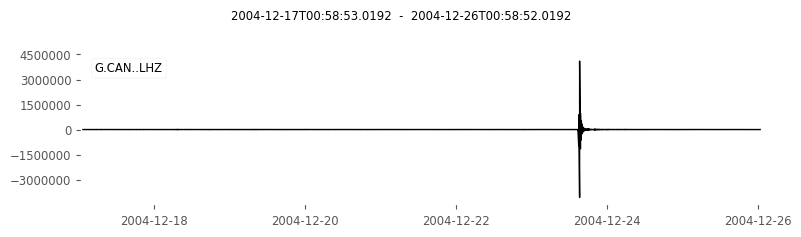

In [3]:
# Getting the waveforms

client = Client("IRIS")
t = UTCDateTime("2004-12-26T00:58:53.0")
starttime = t-(9*24*3600) # 10 days before the Sumatra earthquake
endtime = t # the original time of the Sumatra earthquake

st = client.get_waveforms("G", "CAN", "*", "LHZ", starttime, endtime, attach_response=True)
print(st)

st.plot()

# Plotting signals
tr = st[0]
trace_data = tr.data
plt.plot(tr.data)

1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-22T06:58:53.411900Z - 2004-12-26T00:58:52.411900Z | 1.0 Hz, 324000 samples


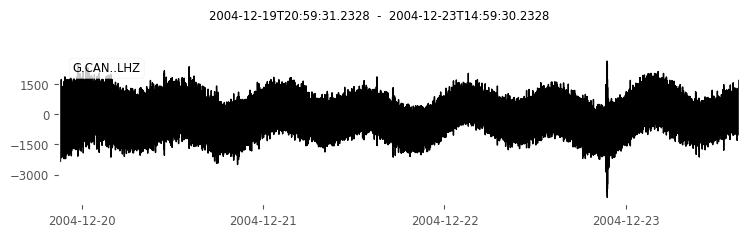

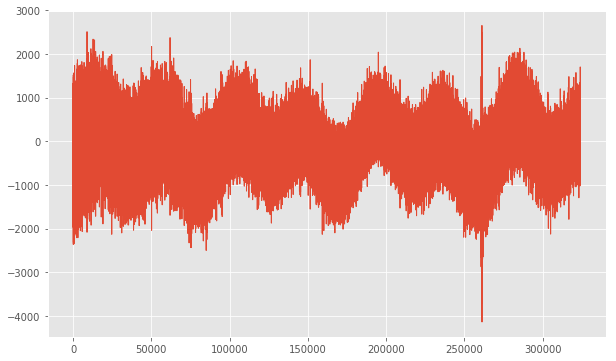

In [8]:
# Remove obvious earthquake 
t1 = UTCDateTime("2004-12-23T14:59:30.9")
starttime1 = t1-(90*3600) # 90 hours before the New Zealand earthquake
endtime1 = t1 # the original time of the New Zealand earthquake

st1 = client.get_waveforms("G", "CAN", "*", "LHZ", starttime1, endtime1, attach_response=True)
print(st)

st1.plot()

# Plotting signals
tr1 = st1[0]
trace_data = tr1.data
plt.plot(tr1.data)